In [1]:
# Importing Necessay Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# reading the data
data = pd.read_csv('Netflix-Subscriptions.csv')
print(data.head())

  Time Period  Subscribers
0  01/04/2013     34240000
1  01/07/2013     35640000
2  01/10/2013     38010000
3  01/01/2014     41430000
4  01/04/2014     46130000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time Period  42 non-null     object
 1   Subscribers  42 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 804.0+ bytes


In [7]:
data.describe()

,Subscribers
count,4.200000e+01
mean,1.304243e+08
std,6.891896e+07
min,3.424000e+07
25%,6.722500e+07
50%,1.216250e+08
75%,2.015325e+08
max,2.383900e+08


In [9]:
data.isna().sum()

Time Period    0
Subscribers    0
dtype: int64

## Convert Time Period to Datetime

The dataset contains subscription counts of Netflix at the start of each quarter from 2013 to 2023. Before moving forward, let’s convert the Time Period column into a datetime format:

In [24]:
data['Time Period'] = pd.to_datetime(
    data['Time Period'],
    format='%d/%m/%Y'
)

## Now let’s have a look at the quarterly subscription growth of Netflix:

In [39]:
data.index

RangeIndex(start=0, stop=42, step=1)

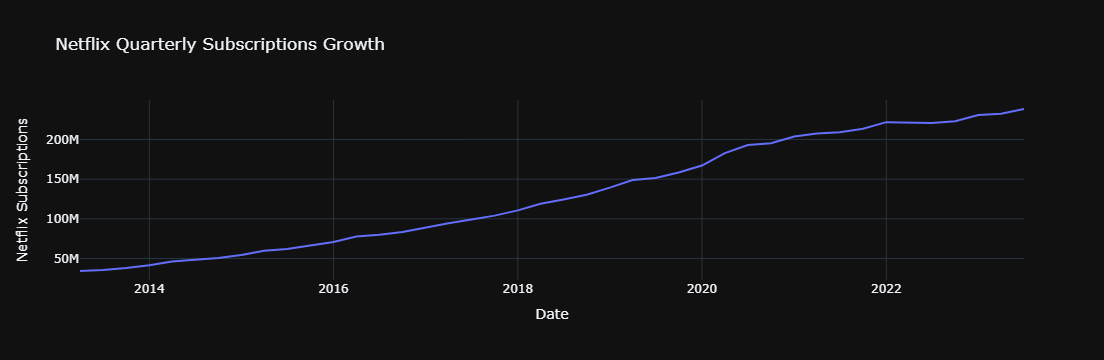

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Time Period'],
                         y=data['Subscribers'],
                         mode='lines', name='Subscribers'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                  xaxis_title='Date',
                  yaxis_title='Netflix Subscriptions', height=400, template='plotly_dark')
fig.show()

🔍 Insights to Write:

Consistent upward growth over time

Minor slowdowns in certain periods

Indicates strong long-term customer acquisition

In the above graph, we can see that the growth of Netflix subscribers is not seasonal. So we can use a forecasting technique like ARIMA in this dataset.

### Now let’s have a look at the quarterly growth rate of subscribers at Netflix:

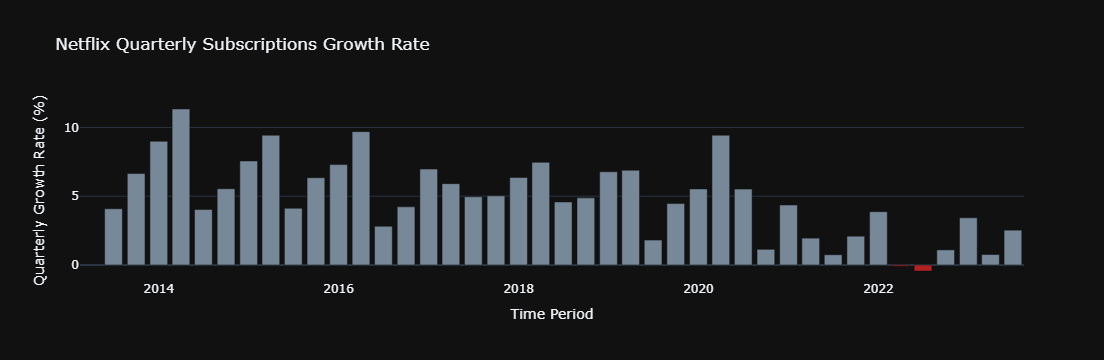

In [73]:
# Calculate the quarterly growth rate
data['Quarterly Growth Rate'] = data['Subscribers'].pct_change() * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar Color'] = data['Quarterly Growth Rate'].apply(lambda x: 'lightslategrey' if x > 0 else 'firebrick')

# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Time Period'],
    y=data['Quarterly Growth Rate'],
    marker_color=data['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)', height=400, template='plotly_dark')
fig.show()

🔍 Insights:

Identifies high growth quarters

Reveals slowdowns or plateaus

Useful for forecasting future momentum

## Rolling Trend

In [66]:
data['Rolling_4Q'] = (data['Subscribers'].rolling(window=4).mean())

## Actual vs Smoothed Trend

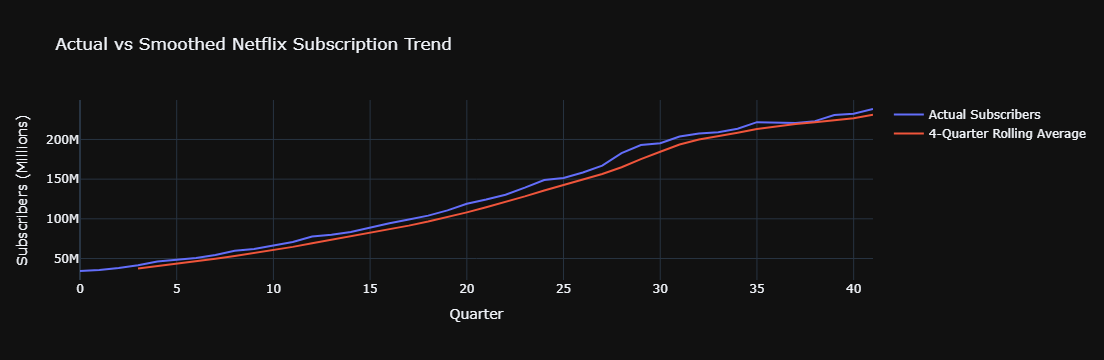

In [71]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Subscribers'],
    mode='lines',
    name='Actual Subscribers'
))

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Rolling_4Q'],
    mode='lines',
    name='4-Quarter Rolling Average'
))

fig.update_layout(
    title='Actual vs Smoothed Netflix Subscription Trend',
    xaxis_title='Quarter',
    yaxis_title='Subscribers (Millions)',
    template='plotly_dark', height=400
)

fig.show()

🔍 Insights:

Rolling average shows stable long-term trend

Reduces short-term volatility

### Now let’s have a look at the yearly growth rate:

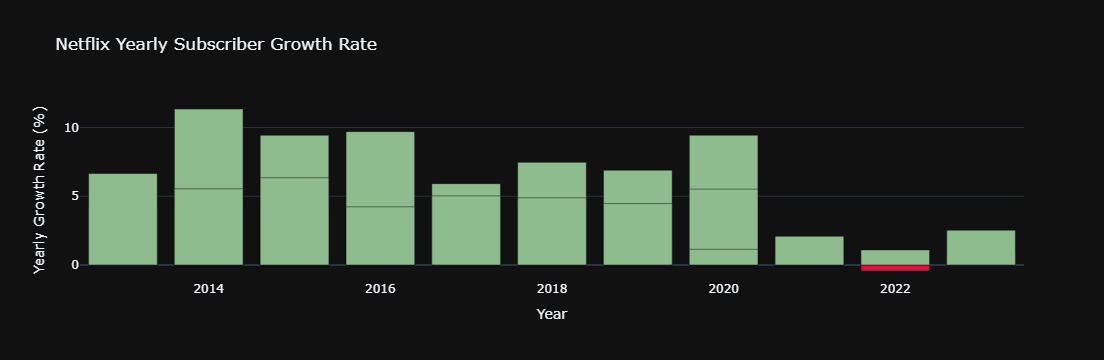

In [89]:
# Calculate the yearly growth rate
data['Year'] = data['Time Period'].dt.year
yearly_growth = data.groupby('Year')['Subscribers'].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar Color'] = yearly_growth.apply(lambda x: 'darkseagreen' if x > 0 else 'crimson')

# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Year'],
    y=yearly_growth,
    marker_color=data['Bar Color'],
    name='Yearly Growth Rate',
    base='overlay'
))
fig.update_layout(title='Netflix Yearly Subscriber Growth Rate',
                  xaxis_title='Year',
                  yaxis_title='Yearly Growth Rate (%)', template='plotly_dark', height=400)
fig.show()

## Seasonal Pattern by Quarter

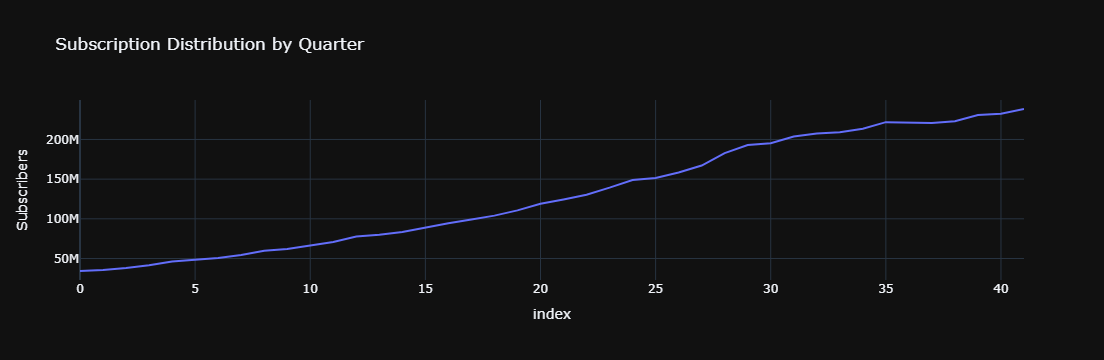

In [107]:
data['Quarter'] = data.index

fig = px.line(
    data,
    x=data.index,
    y='Subscribers',
    title='Subscription Distribution by Quarter'
)

fig.update_layout(template='plotly_dark', height=400)
fig.show()

🔍 Insights:

Identifies seasonal effects

Certain quarters may show stronger growth

## Anomaly / Spike Detection

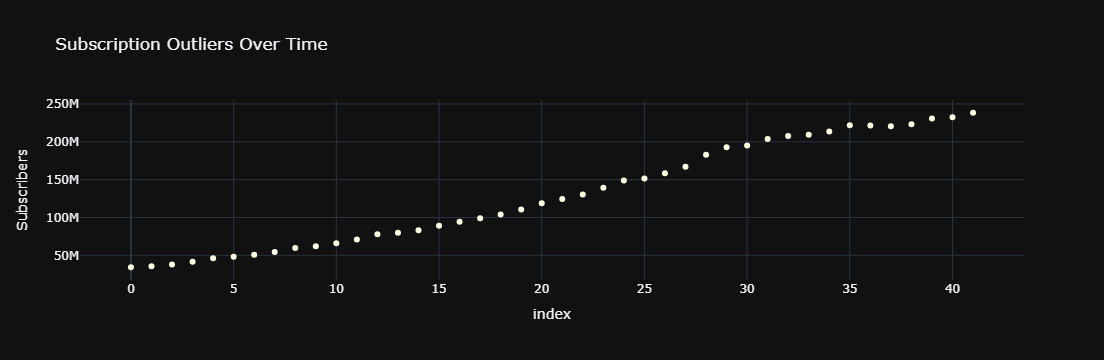

In [119]:
fig = px.scatter(
    data,
    x=data.index,
    y='Subscribers',
    title='Subscription Outliers Over Time',
    color_discrete_sequence=px.colors.sequential.YlOrBr
)

fig.update_layout(template='plotly_dark', height=400)
fig.show()

# Using ARIMA for Forecasting Netflix Quarterly Subscriptions

Now let’s get started with Time Series Forecasting using ARIMA to forecast the number of subscriptions of Netflix using Python. I will start by converting the data into a time series format:

## Check Stationarity

In [104]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['Subscribers'])

print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Statistic: 0.5105104306987093
p-value: 0.985189075554706


## Differencing the Data

In [21]:
data['Subscribers_diff'] = data['Subscribers'].diff()
data.dropna(inplace=True)

In [31]:
re_check = adfuller(data['Subscribers_diff'])[1]
print(f"The Stationarity: {re_check:.6f}")

The Stationarity: 0.000179


Now let’s find the value of p and q by plotting the ACF and PACF of differenced time series:

## Identify p and q (ACF & PACF)

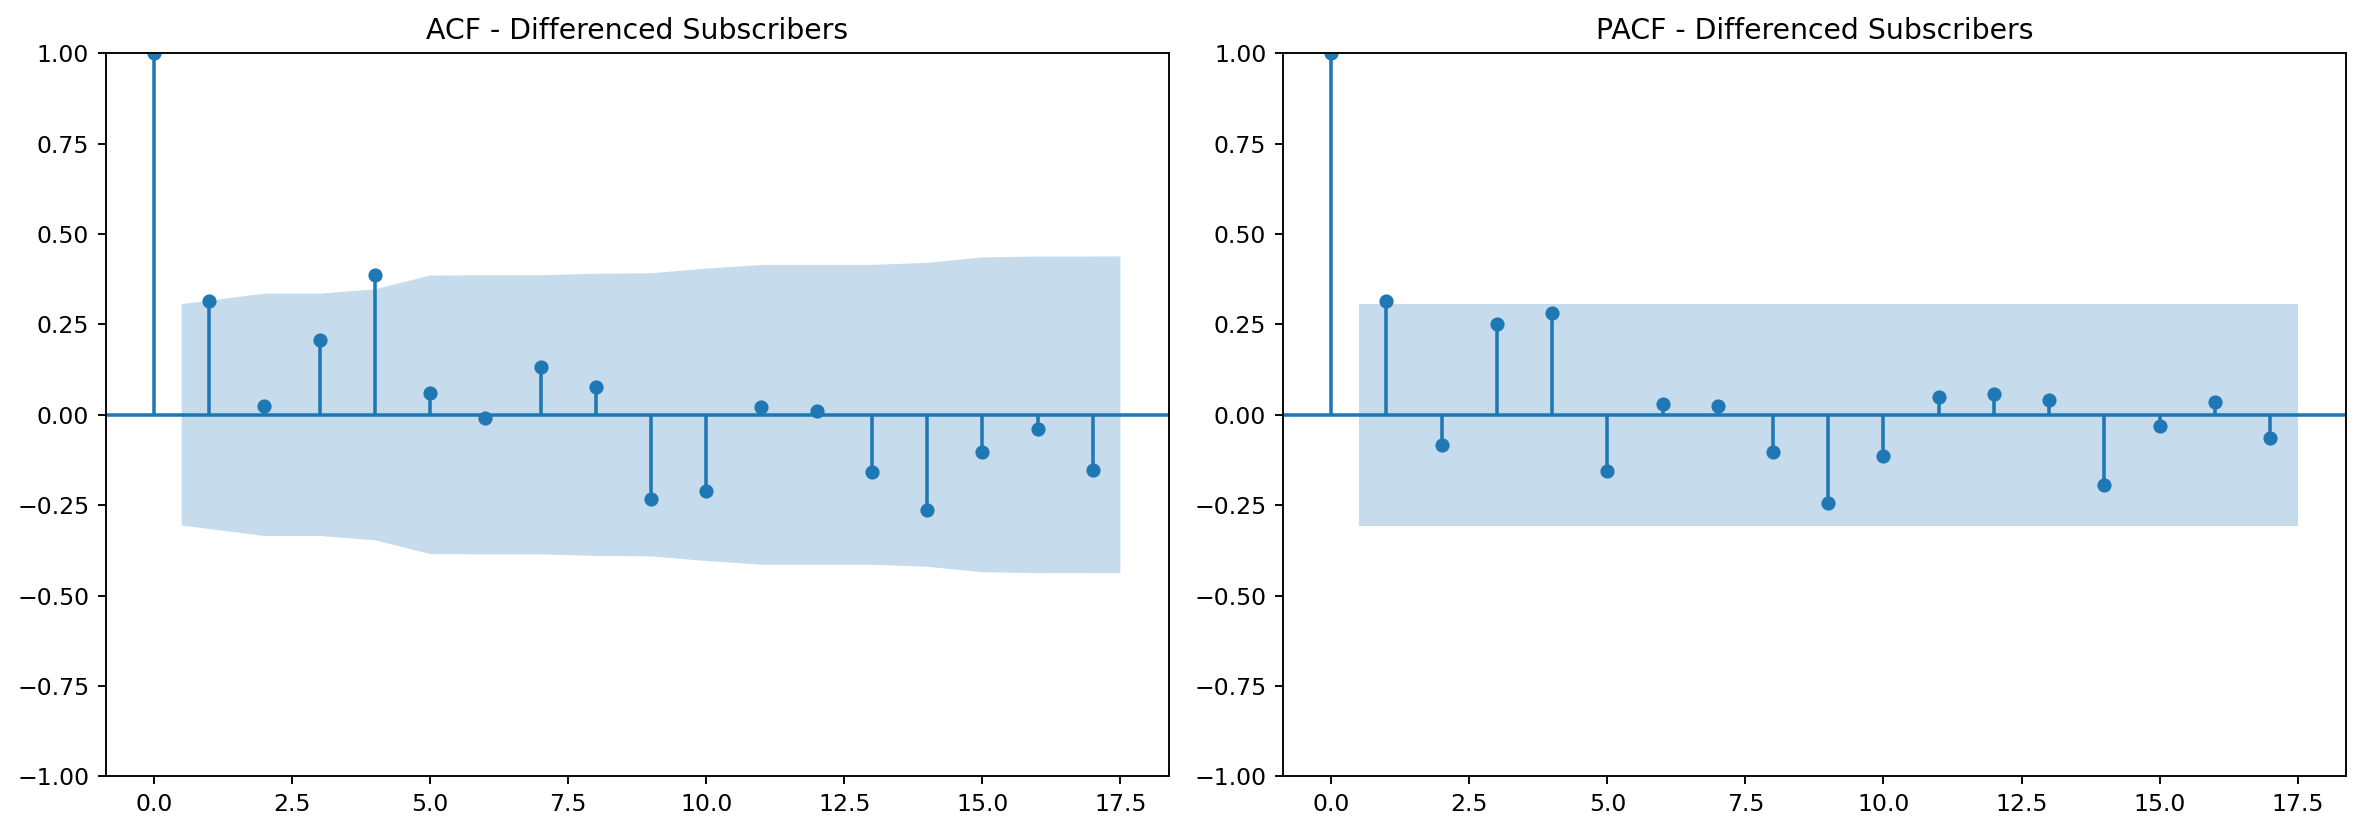

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=170)

# ACF plot
plot_acf(data['Subscribers_diff'], ax=axes[0])
axes[0].set_title('ACF - Differenced Subscribers')

# PACF plot
plot_pacf(data['Subscribers_diff'], ax=axes[1])
axes[1].set_title('PACF - Differenced Subscribers')

plt.tight_layout()
plt.show()

Here we first calculated the differenced time series from the original time_series, removed any NaN values resulting from the differencing, and then plotted the ACF and PACF to provide insights into the potential order of the AR and MA components in the time series. These plots are useful for determining the appropriate parameters when using the ARIMA model for time series forecasting.

Based on the plots, we find that p=1 and q=1. The ACF plot cuts off at lag 1, indicating q=1, and the PACF plot also cuts off at lag 1, indicating p=1. As there is a linear trend in the subscription growth rate, we can set the value of d as 1 to remove the linear trend, making the time series stationary.

Now here’s how to use the ARIMA model on our data:

# Build ARIMA Model

In [61]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(
    data['Subscribers'],
    order=(1, 1, 1)
)

model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   41
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -656.511
Date:                Mon, 29 Dec 2025   AIC                           1319.021
Time:                        20:09:56   BIC                           1324.088
Sample:                             0   HQIC                          1320.853
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.016     64.002      0.000       0.969       1.030
ma.L1         -0.9882      0.213     -4.645      0.000      -1.405      -0.571
sigma2      1.211e+13   1.06e-14   1.15e+27      0.0

## Forecast Future Subscriptions

In [82]:
forecast = model_fit.forecast(steps=5)
forecast.astype(int)

41    243390713
42    248389229
43    253385549
44    258379675
45    263371607
Name: predicted_mean, dtype: int32

## Visualize Forecast

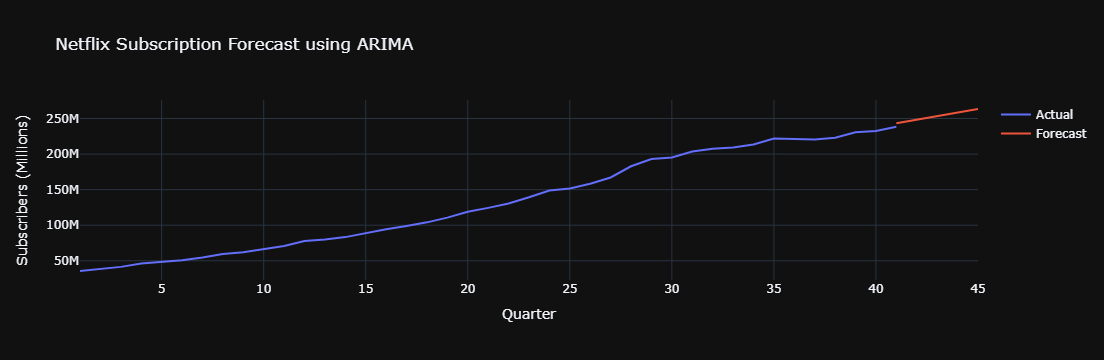

In [96]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Subscribers'],
    mode='lines',
    name='Actual'
))

fig.add_trace(go.Scatter(
    x=forecast.index,
    y=forecast,
    mode='lines',
    name='Forecast'
))

fig.update_layout(
    title='Netflix Subscription Forecast using ARIMA',
    xaxis_title='Quarter',
    yaxis_title='Subscribers (Millions)',
    template='plotly_dark',
    height=400
)

fig.show()

##### The slight gap occurs because ARIMA predicts the expected next value based on historical patterns and differenced data. It does not force the forecast to start exactly at the last observed point, which is normal behavior.

🧠 Is This a Problem? ❌

No. Absolutely not.

✔ The difference is very small relative to the scale
✔ Trend continuity is preserved
✔ Model is behaving correctly

So this is how you can forecast subscription counts for a given time period using Time Series Forecasting and Python.

## Save the Trained Model

In [108]:
import joblib

joblib.dump(model_fit, "arima_netflix_model.pkl")

['arima_netflix_model.pkl']